In [1]:
# Choose either Re=1000 or Re=100
Re=10000

# FOM

In [2]:
import numpy as np
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time, sys
import pickle
from scipy.io import savemat

In [3]:
np.set_printoptions(threshold=sys.maxsize)

In [4]:
# Set parameters
if Re==10000:
    nx=60
    ny=60
    nt=1500
elif Re==100:
    nx=60
    ny=60
    nt=1500
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))
    
nxy=(nx-2)*(ny-2)
dx=1/(nx-1)
dy=1/(ny-1)
dt=2/nt

maxitr=10
tol=1e-8

I=sp.eye(nxy,format='csr')

# full indicies, free indicies, fixed indicies
[xv,yv]=np.meshgrid(np.linspace(0,1,nx),np.linspace(0,1,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())
x0_multi_index=(multi_index_j[1:-1,0].flatten(),multi_index_i[1:-1,0].flatten())
x1_multi_index=(multi_index_j[1:-1,-1].flatten(),multi_index_i[1:-1,-1].flatten())
y0_multi_index=(multi_index_j[0,1:-1].flatten(),multi_index_i[0,1:-1].flatten())
y1_multi_index=(multi_index_j[-1,1:-1].flatten(),multi_index_i[-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)
x0_raveled_indicies=np.ravel_multi_index(x0_multi_index,dims)
x1_raveled_indicies=np.ravel_multi_index(x1_multi_index,dims)
x01_raveled_indicies=np.concatenate((x0_raveled_indicies,x1_raveled_indicies))
y0_raveled_indicies=np.ravel_multi_index(y0_multi_index,dims)
y1_raveled_indicies=np.ravel_multi_index(y1_multi_index,dims)
y01_raveled_indicies=np.concatenate((y0_raveled_indicies,y1_raveled_indicies))
fixed_raveled_indicies=np.setdiff1d(full_raveled_indicies,free_raveled_indicies)

# boundary one-hot vector
x0_one_hot=np.eye(nx-2)[0]
y0_one_hot=np.eye(ny-2)[0]
x1_one_hot=np.eye(nx-2)[-1]
y1_one_hot=np.eye(ny-2)[-1]

# inner grid
inner_multi_index_i,inner_multi_index_j=np.meshgrid(np.arange(nx-2),np.arange(ny-2),indexing='xy')
inner_x_multi_index=(np.concatenate((inner_multi_index_j[:,0].flatten(),inner_multi_index_j[:,-1].flatten())),
                     np.concatenate((inner_multi_index_i[:,0].flatten(),inner_multi_index_i[:,-1].flatten())))
inner_y_multi_index=(np.concatenate((inner_multi_index_j[0,:].flatten(),inner_multi_index_j[-1,:].flatten())),
                     np.concatenate((inner_multi_index_i[0,:].flatten(),inner_multi_index_i[-1,:].flatten())))

inner_dims=(ny-2,nx-2)
inner_x_raveled_indicies=np.ravel_multi_index(inner_x_multi_index,inner_dims)
inner_y_raveled_indicies=np.ravel_multi_index(inner_y_multi_index,inner_dims)

In [5]:
# first order derivative
# central
Mb=sp.diags([np.ones(nx-2),-np.ones(nx-2)],[0,-1],(nx-2,nx-2))
M=sp.kron(sp.eye(ny-2),Mb,format="csr")

Ib=sp.eye(nx-2)
N=sp.kron(sp.diags([np.ones(ny-2),-np.ones(ny-2)],[0,-1],(ny-2,ny-2)),Ib,format="csr")

# laplacian operator
Dxb=sp.diags([-2*np.ones(nx-2),np.ones(nx-2),np.ones(nx-2)],[0,-1,1],(nx-2,nx-2))
Dx=sp.kron(sp.eye(ny-2),Dxb,format="csr")

Ib=sp.eye(nx-2)
Dy=sp.kron(sp.diags([-2*np.ones(ny-2),np.ones(ny-2),np.ones(ny-2)],[0,-1,1],(ny-2,ny-2)),Ib,format="csr")

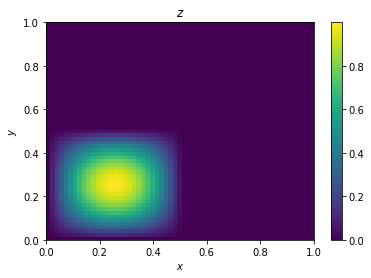

In [6]:
# IC
zv=np.sin(2*np.pi*xv)*np.sin(2*np.pi*yv)
zv[np.nonzero(xv>0.5)]=0.0
zv[np.nonzero(yv>0.5)]=0.0
z=zv.flatten()

fig_z = plt.figure()
# ax_z = Axes3D(fig_z)
# ax_z.plot_surface(xv, yv, zv,cmap=cm.viridis, rstride=1, cstride=1)
# ax_z.view_init(elev=30,azim=60)
ax_z = fig_z.gca()
p_z=ax_z.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), z.reshape(ny,nx))
cb_z=fig_z.colorbar(p_z,ax=ax_z)
ax_z.set_xlabel('$x$')
ax_z.set_ylabel('$y$')
plt.title('$z$')
plt.show()

u0=z.copy()
v0=z.copy()

In [7]:
# boundary for first order derivative term
Bdudx0_cur=np.kron(u0[x0_raveled_indicies],x0_one_hot)
Bdudy0_cur=np.kron(y0_one_hot,u0[y0_raveled_indicies])
Bdvdx0_cur=np.kron(v0[x0_raveled_indicies],x0_one_hot)
Bdvdy0_cur=np.kron(y0_one_hot,v0[y0_raveled_indicies])
Bdudx1_cur=np.kron(u0[x1_raveled_indicies],x1_one_hot)
Bdudy1_cur=np.kron(y1_one_hot,u0[y1_raveled_indicies])
Bdvdx1_cur=np.kron(v0[x1_raveled_indicies],x1_one_hot)
Bdvdy1_cur=np.kron(y1_one_hot,v0[y1_raveled_indicies])
    
# boundary for second order derivative term
bxu_cur=np.zeros(nxy)
byu_cur=np.zeros(nxy)
bxv_cur=np.zeros(nxy)
byv_cur=np.zeros(nxy)

bxu_cur[inner_x_raveled_indicies]=u0[x01_raveled_indicies]
byu_cur[inner_y_raveled_indicies]=u0[y01_raveled_indicies]
bxv_cur[inner_x_raveled_indicies]=v0[x01_raveled_indicies]
byv_cur[inner_y_raveled_indicies]=v0[y01_raveled_indicies]

In [8]:
def r(u_free,v_free,u_free_prev,v_free_prev,Mu_free,Mv_free,Nu_free,Nv_free,
      Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur,
      bxu_cur,bxv_cur,byu_cur,byv_cur):
    
    f_u=(-1/dx*(u_free*(Mu_free - Bdudx0_cur))
    -1/dy*(v_free*(Nu_free - Bdudy0_cur))
    +1/(Re*dx**2)*(Dx.dot(u_free) + bxu_cur)
    +1/(Re*dy**2)*(Dy.dot(u_free) + byu_cur))
    f_v=(-1/dx*(u_free*(Mv_free - Bdvdx0_cur))
    -1/dy*(v_free*(Nv_free - Bdvdy0_cur))
    +1/(Re*dx**2)*(Dx.dot(v_free) + bxv_cur)
    +1/(Re*dy**2)*(Dy.dot(v_free) + byv_cur))
        
    r_u=u_free-u_free_prev-dt*f_u
    r_v=v_free-v_free_prev-dt*f_v
    
    return np.concatenate((r_u,r_v))

def J(u_free,v_free,Mu_free,Mv_free,Nu_free,Nv_free,
      Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur):
    
    df_udu = (-1/dx*(sp.diags(Mu_free - Bdudx0_cur,0,(nxy,nxy),format="csr") 
                        + sp.diags(u_free,0,(nxy,nxy),format="csr").dot(M))
    -1/dy*sp.diags(v_free,0,(nxy,nxy),format="csr").dot(N)
    +1/(Re*dx**2)*Dx
    +1/(Re*dy**2)*Dy)
    df_udv = -1/dy*sp.diags(Nu_free - Bdudy0_cur,0,(nxy,nxy),format="csr")
    df_vdu = -1/dx*sp.diags(Mv_free - Bdvdx0_cur,0,(nxy,nxy),format="csr")
    df_vdv = (-1/dx*sp.diags(u_free,0,(nxy,nxy),format="csr").dot(M)
    -1/dy*(sp.diags(Nv_free - Bdvdy0_cur,0,(nxy,nxy),format="csr")
               + sp.diags(v_free,0,(nxy,nxy),format="csr").dot(N))
    +1/(Re*dx**2)*Dx
    +1/(Re*dy**2)*Dy)
    
    return sp.bmat([[I-dt*df_udu,-dt*df_udv],[-dt*df_vdu,I-dt*df_vdv]],format='csr')

In [9]:
t_start=time.time()

# solution snapshot
u_full=np.zeros(((nt+1),ny*nx))
v_full=np.zeros(((nt+1),ny*nx))

# IC
u_full[0]=np.copy(u0)
v_full[0]=np.copy(v0)
u0_free=u0[free_raveled_indicies]
v0_free=v0[free_raveled_indicies]

for k in range(nt):
#     print("")
#     print(k,"th time step:")
    
    u_free_prev=np.copy(u_full[k,free_raveled_indicies])
    v_free_prev=np.copy(v_full[k,free_raveled_indicies])
    
    u_free=np.copy(u_full[k,free_raveled_indicies])
    v_free=np.copy(v_full[k,free_raveled_indicies])

    Mu_free=M.dot(u_free)
    Mv_free=M.dot(v_free)
    Nu_free=N.dot(u_free)
    Nv_free=N.dot(v_free)
    
    residual=r(u_free,v_free,u_free_prev,v_free_prev,Mu_free,Mv_free,Nu_free,Nv_free,
               Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur,
               bxu_cur,bxv_cur,byu_cur,byv_cur)
        
    for itr in range(maxitr):
        jacobian=J(u_free,v_free,Mu_free,Mv_free,Nu_free,Nv_free,
                   Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur)
        
        delta_free=spsolve(jacobian, -residual)
        
        u_free+=delta_free[:nxy]
        v_free+=delta_free[nxy:]

        Mu_free=M.dot(u_free)
        Mv_free=M.dot(v_free)
        Nu_free=N.dot(u_free)
        Nv_free=N.dot(v_free)
        
        residual=r(u_free,v_free,u_free_prev,v_free_prev,Mu_free,Mv_free,Nu_free,Nv_free,
                   Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur,
                   bxu_cur,bxv_cur,byu_cur,byv_cur)
        
        R=np.linalg.norm(residual)
#         print(itr,"th Newton iteration", "R:", R)
        
        if R<tol:
            u_full[k+1,free_raveled_indicies]=np.copy(u_free)
            v_full[k+1,free_raveled_indicies]=np.copy(v_free)
            # BC from exact solution
            u_full[k+1,fixed_raveled_indicies]=np.copy(u0[fixed_raveled_indicies])
            v_full[k+1,fixed_raveled_indicies]=np.copy(v0[fixed_raveled_indicies])
            break
            
    if R>=tol:
        print("\n non converged after {}th iteration".format(maxitr))
        break     

#     u_full[k+1,free_raveled_indicies]=np.copy(u_free)
#     v_full[k+1,free_raveled_indicies]=np.copy(v_free)
#     # BC from exact solution
#     u_full[k+1,fixed_raveled_indicies]=np.copy(u0[fixed_raveled_indicies])
#     v_full[k+1,fixed_raveled_indicies]=np.copy(v0[fixed_raveled_indicies])

t_elapsed=time.time()-t_start
print()
print('Time elapsed: {} sec'.format(t_elapsed))


Time elapsed: 168.055997133255 sec


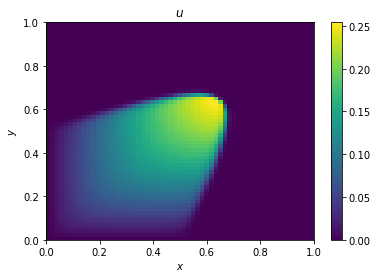

In [10]:
# plot
fig_u = plt.figure()
# ax_u = Axes3D(fig_u)
# ax_u.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), u_full[-1].reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
# ax_u.view_init(elev=30,azim=30)
ax_u = fig_u.gca()
p_u=ax_u.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (u_full[-1]).reshape(ny,nx))
cb_u=fig_u.colorbar(p_u,ax=ax_u)
ax_u.set_xlabel('$x$')
ax_u.set_ylabel('$y$')
plt.title('$u$')
plt.show()

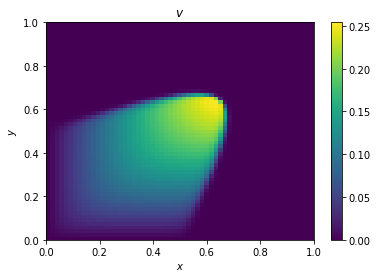

In [11]:
# plot
fig_v = plt.figure()
# ax_v = Axes3D(fig_v)
# ax_v.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), v_full[-1].reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
# ax_v.view_init(elev=30,azim=60)
ax_v = fig_v.gca()
p_v=ax_v.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (v_full[-1]).reshape(ny,nx))
cb_v=fig_v.colorbar(p_v,ax=ax_v)
ax_v.set_xlabel('$x$')
ax_v.set_ylabel('$y$')
plt.title('$v$')
plt.show()

# Galerkin

In [12]:
if Re==10000:
    file_name_AE="./model/AE_high_Re_v3_batch_240.p"
    latent_dim=5
elif Re==100:
    file_name_AE="./model/AE_low_Re_v3_batch_240.p"
    latent_dim=5
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

AE = pickle.load(open(file_name_AE,'rb'))

en_wu1=AE['en_wu1']
en_bu1=AE['en_bu1']
en_wu2=AE['en_wu2']
de_wu1=AE['de_wu1']
de_bu1=AE['de_bu1']
de_wu2=AE['de_wu2']
de_wu1T=AE['de_wu1T']
de_wu2T=AE['de_wu2T']
de_wu2_sp=AE['de_wu2_sp']
de_wu2T_sp=AE['de_wu2T_sp']
u_ref=AE['u_ref']

en_wv1=AE['en_wv1']
en_bv1=AE['en_bv1']
en_wv2=AE['en_wv2']
de_wv1=AE['de_wv1']
de_bv1=AE['de_bv1']
de_wv2=AE['de_wv2']
de_wv1T=AE['de_wv1T']
de_wv2T=AE['de_wv2T']
de_wv2_sp=AE['de_wv2_sp']
de_wv2T_sp=AE['de_wv2T_sp']
v_ref=AE['v_ref']

In [13]:
def sigmoid_np(input):
    return (1.0/(1.0+np.exp(-input))).astype('float32')

def encoder_u_np_forward(x):
    z1 = en_wu1.dot(x) + en_bu1
    a1 = sigmoid_np(z1)
    y = en_wu2.dot(a1)   
    return y

def decoder_u_np_forward(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = de_wu2.dot(a1)  
    return y

def decoder_u_sp_forward(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(de_wu2_sp,a1)
    return y

def encoder_v_np_forward(x):
    z1 = en_wv1.dot(x) + en_bv1
    a1 = sigmoid_np(z1)
    y = en_wv2.dot(a1)   
    return y

def decoder_v_np_forward(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = de_wv2.dot(a1)   
    return y

def decoder_v_sp_forward(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(de_wv2_sp,a1)
    return y

def decoder_u_np_forward_backwardT(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = de_wu2.dot(a1)

    dout = de_wu1T
    dout = (a1*(1-a1))*dout
    dydxT = dout.dot(de_wu2T)   
    return y,dydxT

def decoder_u_sp_forward_backwardT(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(de_wu2_sp,a1)

    dout = de_wu1T
    dout = (a1*(1-a1))*dout
    dydxT = sp.csr_matrix.dot(dout,de_wu2T_sp)
    return y,dydxT

def decoder_v_np_forward_backwardT(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = de_wv2.dot(a1)

    dout = de_wv1T
    dout = (a1*(1-a1))*dout
    dydxT = dout.dot(de_wv2T)   
    return y,dydxT

def decoder_v_sp_forward_backwardT(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(de_wv2_sp,a1)

    dout = de_wv1T
    dout = (a1*(1-a1))*dout
    dydxT = sp.csr_matrix.dot(dout,de_wv2T_sp)
    return y,dydxT

In [14]:
I_hat=np.eye(latent_dim,dtype='float32')

maxitr=4
tol=1e-6

u_hat0=encoder_u_np_forward(u0[free_raveled_indicies].astype('float32')-u_ref)
v_hat0=encoder_v_np_forward(v0[free_raveled_indicies].astype('float32')-v_ref)

In [15]:
M=M.astype('float32')
N=N.astype('float32')

Dx=Dx.astype('float32')
Dy=Dy.astype('float32')

MT=M.T
NT=N.T

Mu_ref=M.dot(u_ref)
Nu_ref=N.dot(u_ref)
Mv_ref=M.dot(v_ref)
Nv_ref=N.dot(v_ref)

Dxu_ref=Dx.dot(u_ref)
Dyu_ref=Dy.dot(u_ref)
Dxv_ref=Dx.dot(v_ref)
Dyv_ref=Dy.dot(v_ref)

In [16]:
au1_cur=(-1/dx*u_ref*(Mu_ref-Bdudx0_cur)-1/dy*v_ref*(Nu_ref-Bdudy0_cur) \
+1/(Re*dx**2)*(Dxu_ref+bxu_cur)+1/(Re*dy**2)*(Dyu_ref+byu_cur)).astype('float32')
Au2_cur=(-1/dx*(sp.diags(u_ref,format='csr').dot(M)+sp.diags(Mu_ref-Bdudx0_cur,format='csr')) \
-1/dy*sp.diags(v_ref,format='csr').dot(N) \
+1/(Re*dx**2)*Dx+1/(Re*dy**2)*Dy).astype('float32')
au3_cur=(-1/dy*(Nu_ref-Bdudy0_cur)).astype('float32')

av1_cur=(-1/dx*u_ref*(Mv_ref-Bdvdx0_cur)-1/dy*v_ref*(Nv_ref-Bdvdy0_cur) \
+1/(Re*dx**2)*(Dxv_ref+bxv_cur)+1/(Re*dy**2)*(Dyv_ref+byv_cur)).astype('float32')
av2_cur=(-1/dx*(Mv_ref-Bdvdx0_cur)).astype('float32')
Av3_cur=(-1/dx*sp.diags(u_ref,format='csr').dot(M) \
-1/dy*(sp.diags(v_ref,format='csr').dot(N)+sp.diags(Nv_ref-Bdvdy0_cur,format='csr')) \
+1/(Re*dx**2)*Dx+1/(Re*dy**2)*Dy).astype('float32')

Au2T_cur=Au2_cur.T
Av3T_cur=Av3_cur.T

In [17]:
def theta_u(g_u,g_v,Mg_u,Ng_u):
    return -1/dx*g_u*Mg_u-1/dy*g_v*Ng_u

def theta_v(g_u,g_v,Mg_v,Ng_v):
    return -1/dx*g_u*Mg_v-1/dy*g_v*Ng_v

In [18]:
def dtheta_udu_hatT(g_u,g_v,Mg_u,Jg_uT,Jg_uTMT,Jg_uTNT):
    return -1/dx*(Mg_u*Jg_uT+g_u*Jg_uTMT)-1/dy*g_v*Jg_uTNT

def dtheta_udv_hatT(Ng_u,Jg_vT):
    return -1/dy*Ng_u*Jg_vT

def dtheta_vdu_hatT(Mg_v,Jg_uT):
    return -1/dx*Mg_v*Jg_uT

def dtheta_vdv_hatT(g_u,g_v,Ng_v,Jg_vT,Jg_vTMT,Jg_vTNT):
    return -1/dx*g_u*Jg_vTMT-1/dy*(Ng_v*Jg_vT+g_v*Jg_vTNT)

In [19]:
def r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT_pinv,Jg_vT_pinv,\
          au1_cur,Au2_cur,au3_cur,av1_cur,av2_cur,Av3_cur):
    r_u_hat=u_hat-u_hat_prev-dt*(au1_cur+Au2_cur.dot(g_u)+au3_cur*g_v+theta_u(g_u,g_v,Mg_u,Ng_u)).dot(Jg_uT_pinv)
    r_v_hat=v_hat-v_hat_prev-dt*(av1_cur+av2_cur*g_u+Av3_cur.dot(g_v)+theta_v(g_u,g_v,Mg_v,Ng_v)).dot(Jg_vT_pinv)
    return np.concatenate((r_u_hat,r_v_hat))

In [20]:
def J_hat(g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT,Jg_vT,Jg_uTMT,Jg_uTNT,Jg_vTMT,Jg_vTNT):
    J_hat11=(I_hat-dt*(sp.csc_matrix.dot(Jg_uT,Au2T_cur)+dtheta_udu_hatT(g_u,g_v,Mg_u,Jg_uT,Jg_uTMT,Jg_uTNT)).dot(Jg_uT_pinv)).T
    J_hat12=(-dt*(au3_cur*Jg_vT+dtheta_udv_hatT(Ng_u,Jg_vT)).dot(Jg_uT_pinv)).T
    J_hat21=(-dt*(av2_cur*Jg_uT+dtheta_vdu_hatT(Mg_v,Jg_uT)).dot(Jg_vT_pinv)).T
    J_hat22=(I_hat-dt*(sp.csc_matrix.dot(Jg_vT,Av3T_cur)+dtheta_vdv_hatT(g_u,g_v,Ng_v,Jg_vT,Jg_vTMT,Jg_vTNT)).dot(Jg_vT_pinv)).T
    return np.block([[J_hat11,J_hat12],[J_hat21,J_hat22]])

In [21]:
t_start_g=time.time()

# solution
u_reduced=np.zeros((nt+1,latent_dim))
v_reduced=np.zeros((nt+1,latent_dim))
u_rom_g=np.zeros((nt+1,ny*nx))
v_rom_g=np.zeros((nt+1,ny*nx))

# IC
u_reduced[0]=np.copy(u_hat0)
v_reduced[0]=np.copy(v_hat0)
u_rom_g[0]=np.copy(u0)
v_rom_g[0]=np.copy(v0)

for k in range(nt):
#     print("")
#     print(k,"th time step:")
    
    u_hat_prev=np.copy(u_reduced[k])
    v_hat_prev=np.copy(v_reduced[k])
    
    u_hat=np.copy(u_reduced[k])
    v_hat=np.copy(v_reduced[k])
    
    g_u,Jg_uT=decoder_u_sp_forward_backwardT(u_hat)
    g_v,Jg_vT=decoder_v_sp_forward_backwardT(v_hat)
    
    Jg_uT_pinv=np.linalg.pinv(Jg_uT)
    Jg_vT_pinv=np.linalg.pinv(Jg_vT)
    
    Mg_u=M.dot(g_u)
    Ng_u=N.dot(g_u)
    Mg_v=M.dot(g_v)
    Ng_v=N.dot(g_v)
    
    Jg_uTMT=sp.csc_matrix.dot(Jg_uT,MT)
    Jg_uTNT=sp.csc_matrix.dot(Jg_uT,NT)
    Jg_vTMT=sp.csc_matrix.dot(Jg_vT,MT)
    Jg_vTNT=sp.csc_matrix.dot(Jg_vT,NT)
    
    residual_hat=r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT_pinv,Jg_vT_pinv,\
                       au1_cur,Au2_cur,au3_cur,av1_cur,av2_cur,Av3_cur)
    
    for itr in range(maxitr):
        Jacobian_hat=J_hat(g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT,Jg_vT,Jg_uTMT,Jg_uTNT,Jg_vTMT,Jg_vTNT)
        
        delta_reduced=np.linalg.solve(Jacobian_hat,-residual_hat)
        
        u_hat+=delta_reduced[:latent_dim]
        v_hat+=delta_reduced[latent_dim:]
        
        g_u,Jg_uT=decoder_u_sp_forward_backwardT(u_hat)
        g_v,Jg_vT=decoder_v_sp_forward_backwardT(v_hat)

        Jg_uT_pinv=np.linalg.pinv(Jg_uT)
        Jg_vT_pinv=np.linalg.pinv(Jg_vT)

        Mg_u=M.dot(g_u)
        Ng_u=N.dot(g_u)
        Mg_v=M.dot(g_v)
        Ng_v=N.dot(g_v)

        Jg_uTMT=sp.csc_matrix.dot(Jg_uT,MT)
        Jg_uTNT=sp.csc_matrix.dot(Jg_uT,NT)
        Jg_vTMT=sp.csc_matrix.dot(Jg_vT,MT)
        Jg_vTNT=sp.csc_matrix.dot(Jg_vT,NT)
    
        residual_hat=r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT_pinv,Jg_vT_pinv,\
                           au1_cur,Au2_cur,au3_cur,av1_cur,av2_cur,Av3_cur)
        
#         # compute residual
#         u_free=u_ref+decoder_u_sp_forward(u_hat)
#         v_free=v_ref+decoder_v_sp_forward(v_hat)
        
#         Mu_free=M.dot(u_free)
#         Mv_free=M.dot(v_free)
#         Nu_free=N.dot(u_free)
#         Nv_free=N.dot(v_free)
        
#         residual=r(u_free,v_free,u_free_prev,v_free_prev,Mu_free,Mv_free,Nu_free,Nv_free,
#                    Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur,
#                    bxu_cur,bxv_cur,byu_cur,byv_cur)
        
#         R_hat=np.linalg.norm(residual_hat)
#         R=np.linalg.norm(residual)
#         print(itr,"th Newton iteration", "R_hat:", "{:.8e}".format(R_hat),"R_tilde","{:.8e}".format(R))
        
        R=np.linalg.norm(residual_hat)
#         print(itr,"th Newton iteration", "R:", "{:.8e}".format(R))
        
        if R<tol:
            u_reduced[k+1]=u_hat.copy()
            v_reduced[k+1]=v_hat.copy()
            u_rom_g[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
            v_rom_g[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
            # BC from exact solution
            u_rom_g[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
            v_rom_g[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()
            break
            
    if R>=tol:
        print("\n non converged after {}th iteration".format(maxitr))
#         break  
        u_reduced[k+1]=u_hat.copy()
        v_reduced[k+1]=v_hat.copy()
        u_rom_g[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
        v_rom_g[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
        # BC from exact solution
        u_rom_g[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
        v_rom_g[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

#     u_reduced[k+1]=u_hat.copy()
#     v_reduced[k+1]=v_hat.copy()
#     u_rom_g[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
#     v_rom_g[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
#     # BC from exact solution
#     u_rom_g[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
#     v_rom_g[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

t_elapsed_g=time.time()-t_start_g
print()
print('Time elapsed: {} sec'.format(t_elapsed_g))


 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th it


 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th it


 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th it


 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

 non converged after 4th iteration

Time elapsed: 193.3000009059906 sec


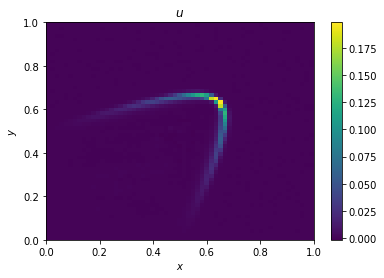

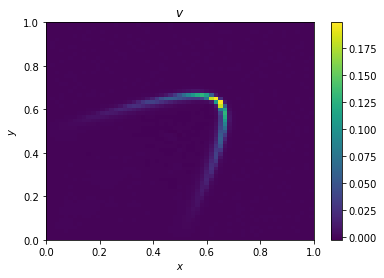

In [25]:
# plot
k=-1

fig_u = plt.figure()
# ax_u = Axes3D(fig_u)
# ax_u.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), (u_full[k]-u_rom_g[k]).reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
# ax_u.view_init(elev=30,azim=30)
ax_u = fig_u.gca()
p_u=ax_u.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (u_full[k]-u_rom_g[k]).reshape(ny,nx))
cb_u=fig_u.colorbar(p_u,ax=ax_u)
ax_u.set_xlabel('$x$')
ax_u.set_ylabel('$y$')
plt.title('$u$')
plt.show()

fig_v = plt.figure()
# ax_v = Axes3D(fig_v)
# ax_v.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), (v_full[k]-v_rom_g[k]).reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
# ax_v.view_init(elev=30,azim=60)
ax_v = fig_v.gca()
p_v=ax_v.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (v_full[k]-v_rom_g[k]).reshape(ny,nx))
cb_v=fig_v.colorbar(p_v,ax=ax_v)
ax_v.set_xlabel('$x$')
ax_v.set_ylabel('$y$')
plt.title('$v$')
plt.show()

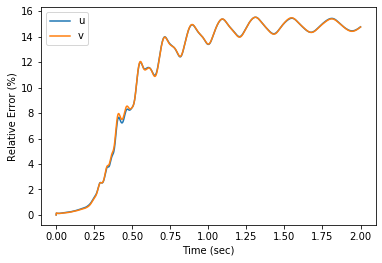

average relative error of u: 9.19162218045349%
average relative error of v: 9.207399994845343%

maximum relative error of u: 15.521100191077583%
maximum relative error of v: 15.52014412035935%


In [26]:
u_rel_err=np.linalg.norm(u_full-u_rom_g,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
v_rel_err=np.linalg.norm(v_full-v_rom_g,ord=2,axis=1)/np.linalg.norm(v_full,ord=2,axis=1)*100
plt.plot(dt*np.arange(nt+1),u_rel_err,dt*np.arange(nt+1),v_rel_err)
plt.xlabel('Time (sec)')
plt.ylabel('Relative Error (%)')
plt.legend(('u','v'))
plt.show()

u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_rom_g,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
v_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(v_full-v_rom_g,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(v_full,ord=2,axis=1)**2))*100

print("average relative error of u: {}%".format(u_avg_rel_err))
print("average relative error of v: {}%".format(v_avg_rel_err))
print()
print("maximum relative error of u: {}%".format(np.max(u_rel_err)))
print("maximum relative error of v: {}%".format(np.max(v_rel_err)))

In [27]:
# speed-up
speed_up=t_elapsed/t_elapsed_g
print("speed-up: {}".format(speed_up))

speed-up: 0.869405050934207


# LSPG

In [21]:
maxitr=4
tol=1e-6

In [22]:
def r_tilde(g_u,g_v,g_u_prev,g_v_prev,Mg_u,Ng_u,Mg_v,Ng_v,\
            au1_cur,Au2_cur,au3_cur,av1_cur,av2_cur,Av3_cur):
    r_u=g_u-g_u_prev-dt*(au1_cur+Au2_cur.dot(g_u)+au3_cur*g_v+theta_u(g_u,g_v,Mg_u,Ng_u))
    r_v=g_v-g_v_prev-dt*(av1_cur+av2_cur*g_u+Av3_cur.dot(g_v)+theta_v(g_u,g_v,Mg_v,Ng_v))
    return np.concatenate((r_u,r_v))

In [23]:
def J_tildeT(g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT,Jg_vT,Jg_uTMT,Jg_uTNT,Jg_vTMT,Jg_vTNT,\
            Au2T_cur,au3_cur,av2_cur,Av3T_cur):
    J11T=Jg_uT-dt*(sp.csc_matrix.dot(Jg_uT,Au2T_cur)+dtheta_udu_hatT(g_u,g_v,Mg_u,Jg_uT,Jg_uTMT,Jg_uTNT))
    J12T=-dt*(au3_cur*Jg_vT+dtheta_udv_hatT(Ng_u,Jg_vT))
    J21T=-dt*(av2_cur*Jg_uT+dtheta_vdu_hatT(Mg_v,Jg_uT))
    J22T=Jg_vT-dt*(sp.csc_matrix.dot(Jg_vT,Av3T_cur)+dtheta_vdv_hatT(g_u,g_v,Ng_v,Jg_vT,Jg_vTMT,Jg_vTNT))
    return np.block([[J11T,J21T],[J12T,J22T]])

In [27]:
t_start_pg=time.time()

# solution
u_reduced=np.zeros((nt+1,latent_dim))
v_reduced=np.zeros((nt+1,latent_dim))
u_rom_pg=np.zeros((nt+1,ny*nx))
v_rom_pg=np.zeros((nt+1,ny*nx))

# residual snapshot
snapshot_r_u=np.array([],dtype='float32')
snapshot_r_v=np.array([],dtype='float32')

# IC
u_reduced[0]=np.copy(u_hat0)
v_reduced[0]=np.copy(v_hat0)
u_rom_pg[0]=np.copy(u0)
v_rom_pg[0]=np.copy(v0)

for k in range(nt):
#     print("")
#     print(k,"th time step:")
    
    u_hat_prev=np.copy(u_reduced[k])
    v_hat_prev=np.copy(v_reduced[k])
    
    g_u_prev=u_rom_pg[k,free_raveled_indicies]-u_ref
    g_v_prev=v_rom_pg[k,free_raveled_indicies]-v_ref
    
    u_hat=np.copy(u_reduced[k])
    v_hat=np.copy(v_reduced[k])
    
    g_u,Jg_uT=decoder_u_sp_forward_backwardT(u_hat)
    g_v,Jg_vT=decoder_v_sp_forward_backwardT(v_hat)
    
    Mg_u=M.dot(g_u)
    Ng_u=N.dot(g_u)
    Mg_v=M.dot(g_v)
    Ng_v=N.dot(g_v)
    
    Jg_uTMT=sp.csc_matrix.dot(Jg_uT,MT)
    Jg_uTNT=sp.csc_matrix.dot(Jg_uT,NT)
    Jg_vTMT=sp.csc_matrix.dot(Jg_vT,MT)
    Jg_vTNT=sp.csc_matrix.dot(Jg_vT,NT)
    
    residual_tilde=r_tilde(g_u,g_v,g_u_prev,g_v_prev,Mg_u,Ng_u,Mg_v,Ng_v,\
                           au1_cur,Au2_cur,au3_cur,av1_cur,av2_cur,Av3_cur)
    Jacobian_tildeT=J_tildeT(g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT,Jg_vT,Jg_uTMT,Jg_uTNT,Jg_vTMT,Jg_vTNT,\
                             Au2T_cur,au3_cur,av2_cur,Av3T_cur)
    residual_hat=Jacobian_tildeT.dot(residual_tilde)
    
#     # store residual tilde
#     snapshot_r_u = np.append(snapshot_r_u,residual_tilde[:nxy])
#     snapshot_r_v = np.append(snapshot_r_v,residual_tilde[nxy:])
        
    for itr in range(maxitr):
        Jacobian_hat=Jacobian_tildeT.dot(Jacobian_tildeT.T)
        
        delta_reduced=np.linalg.solve(Jacobian_hat,-residual_hat)
        
        u_hat+=delta_reduced[:latent_dim]
        v_hat+=delta_reduced[latent_dim:]
        
        g_u,Jg_uT=decoder_u_sp_forward_backwardT(u_hat)
        g_v,Jg_vT=decoder_v_sp_forward_backwardT(v_hat)

        Mg_u=M.dot(g_u)
        Ng_u=N.dot(g_u)
        Mg_v=M.dot(g_v)
        Ng_v=N.dot(g_v)

        Jg_uTMT=sp.csc_matrix.dot(Jg_uT,MT)
        Jg_uTNT=sp.csc_matrix.dot(Jg_uT,NT)
        Jg_vTMT=sp.csc_matrix.dot(Jg_vT,MT)
        Jg_vTNT=sp.csc_matrix.dot(Jg_vT,NT)
    
        residual_tilde=r_tilde(g_u,g_v,g_u_prev,g_v_prev,Mg_u,Ng_u,Mg_v,Ng_v,\
                               au1_cur,Au2_cur,au3_cur,av1_cur,av2_cur,Av3_cur)
        Jacobian_tildeT=J_tildeT(g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT,Jg_vT,Jg_uTMT,Jg_uTNT,Jg_vTMT,Jg_vTNT,\
                                 Au2T_cur,au3_cur,av2_cur,Av3T_cur)
        residual_hat=Jacobian_tildeT.dot(residual_tilde)
        
#         # store residual tilde
#         snapshot_r_u = np.append(snapshot_r_u,residual_tilde[:nxy])
#         snapshot_r_v = np.append(snapshot_r_v,residual_tilde[nxy:])
        
#         R_tilde = np.linalg.norm(residual_tilde)
#         R_hat=np.linalg.norm(residual_hat)
#         print(itr,"th Newton iteration", "R_hat:", "{:.8e}".format(R_hat),"R_tilde","{:.8e}".format(R_tilde))
        
        R=np.linalg.norm(residual_hat)
#         print(itr,"th Newton iteration", "R:", "{:.8e}".format(R))
        
        if R<tol:
            u_reduced[k+1]=u_hat.copy()
            v_reduced[k+1]=v_hat.copy()
            u_rom_pg[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
            v_rom_pg[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
            # BC from exact solution
            u_rom_pg[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
            v_rom_pg[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()
            break
            
    if R>=tol:
        print("\n non converged after {}th iteration".format(maxitr))
        break  

#     u_reduced[k+1]=u_hat.copy()
#     v_reduced[k+1]=v_hat.copy()
#     u_rom_pg[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
#     v_rom_pg[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
#     # BC from exact solution
#     u_rom_pg[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
#     v_rom_pg[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

# snapshot_r_u=snapshot_r_u.reshape(-1,nxy)
# snapshot_r_v=snapshot_r_v.reshape(-1,nxy)
    
t_elapsed_pg=time.time()-t_start_pg
print()
print('Time elapsed: {} sec'.format(t_elapsed_pg))


Time elapsed: 101.08617234230042 sec


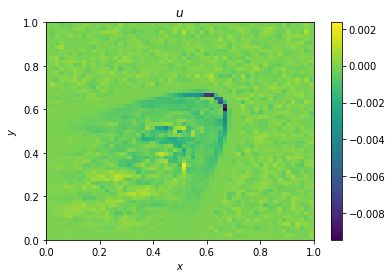

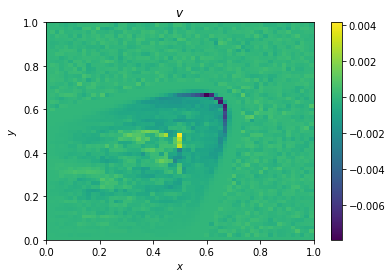

In [28]:
# plot
k=-1

fig_u = plt.figure()
# ax_u = Axes3D(fig_u)
# ax_u.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), (u_full[k]-u_rom_pg[k]).reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
# ax_u.view_init(elev=30,azim=30)
ax_u = fig_u.gca()
p_u=ax_u.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (u_full[k]-u_rom_pg[k]).reshape(ny,nx))
cb_u=fig_u.colorbar(p_u,ax=ax_u)
ax_u.set_xlabel('$x$')
ax_u.set_ylabel('$y$')
plt.title('$u$')
plt.show()

fig_v = plt.figure()
# ax_v = Axes3D(fig_v)
# ax_v.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), (v_full[k]-v_rom_pg[k]).reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
# ax_v.view_init(elev=30,azim=60)
ax_v = fig_v.gca()
p_v=ax_v.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (v_full[k]-v_rom_pg[k]).reshape(ny,nx))
cb_v=fig_v.colorbar(p_v,ax=ax_v)
ax_v.set_xlabel('$x$')
ax_v.set_ylabel('$y$')
plt.title('$v$')
plt.show()

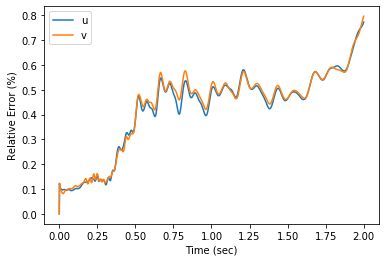

average relative error of u: 0.3436468770880429%
average relative error of v: 0.35026911970515384%

maximum relative error of u: 0.7725064118215828%
maximum relative error of v: 0.7963214598320763%


In [29]:
u_rel_err=np.linalg.norm(u_full-u_rom_pg,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
v_rel_err=np.linalg.norm(v_full-v_rom_pg,ord=2,axis=1)/np.linalg.norm(v_full,ord=2,axis=1)*100
plt.plot(dt*np.arange(nt+1),u_rel_err,dt*np.arange(nt+1),v_rel_err)
plt.xlabel('Time (sec)')
plt.ylabel('Relative Error (%)')
plt.legend(('u','v'))
plt.show()

u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_rom_pg,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
v_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(v_full-v_rom_pg,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(v_full,ord=2,axis=1)**2))*100

print("average relative error of u: {}%".format(u_avg_rel_err))
print("average relative error of v: {}%".format(v_avg_rel_err))
print()
print("maximum relative error of u: {}%".format(np.max(u_rel_err)))
print("maximum relative error of v: {}%".format(np.max(v_rel_err)))

In [30]:
# speed-up
speed_up=t_elapsed/t_elapsed_pg
print("speed-up: {}".format(speed_up))

speed-up: 1.712337075775664


In [31]:
# # save snapshot r_tilde
# # snapshot: residual tilde during NM-ROM (LSPG)
# snapshot_r_tilde={'u':snapshot_r_u,'v':snapshot_r_v}
# if Re==10000:
#     pickle.dump(snapshot_r_tilde,open('./data/snapshot_r_tilde_high_Re_batch_240.p','wb'))
# elif Re==100:
#     pickle.dump(snapshot_r_tilde,open('./data/snapshot_r_tilde_low_Re_batch_240.p','wb'))
# else:
#     raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

## DEIM

In [24]:
def DEIM(phi_f, nfeval=None):
    
    ninf=np.NINF
    n,m=np.shape(phi_f)
    if nfeval==None:
        nfeval=m
        
    if nfeval<m:
        print("ill-posed\n")
        print("set # sampling equal to # modes")
        nfeval=m
        
    div,mod=np.divmod(nfeval,m)
    
    I=np.eye(n)
    
    l=0
    ns=div+mod
    u=np.reshape(phi_f[:,l],(n,1))
    p=np.argsort(-np.abs(u),axis=0,kind='stable')[:ns]
#     p=np.argmax(np.abs(u)) # when ns=1
    ep=np.reshape(I[:,p],(n,ns))
    U=u
    P=ep

    ns=div
    for l in range(1,m):
        u=np.reshape(phi_f[:,l],(n,1))
        PT=np.transpose(P)
        c=np.linalg.lstsq(PT@U,PT@u,rcond=None)[0]
        r=np.abs(u-U@c)
        r[p]=ninf
        p=np.append(p,np.argsort(-r,axis=0,kind='stable')[:ns]) # ns!=1
        ep=np.reshape(I[:,p[-ns:]],(n,ns))
        U=np.concatenate((U,u),axis=1)
        P=np.concatenate((P,ep),axis=1)
        
    return p

In [25]:
# choose # of DEIM basis and DEIM samples
if Re==10000:
    DEIM_basis=55
    DEIM_samples=58
    file_name="./data/snapshot_full_high_Re.p"
    file_name_inter="./data/snapshot_full_inter_high_Re.p"
    file_name_r_tilde='./data/snapshot_r_tilde_high_Re_batch_240.p'
elif Re==100:
    DEIM_basis=50
    DEIM_samples=50
    file_name="./data/snapshot_full_low_Re.p"
    file_name_inter="./data/snapshot_full_inter_low_Re.p"
    file_name_r_tilde='./data/snapshot_r_tilde_low_Re_batch_240.p'
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

In [26]:
# load sanpshots
# snapshot: just full order solution
# temp=pickle.load(open(file_name,'rb'))
# DEIM_snapshot={'u':temp['u'][:,free_raveled_indicies],'v':temp['v'][:,free_raveled_indicies]}

# snapshot: full order solution including intermediate values
DEIM_snapshot=pickle.load(open(file_name_inter,'rb'))

# snapshot: residual tilde during NM-ROM (LSPG)
# DEIM_snapshot=pickle.load(open(file_name_r_tilde,'rb'))

snapshot_u=DEIM_snapshot['u']
snapshot_v=DEIM_snapshot['v']

In [27]:
# do svd decomposition
# U_u,S_u,V_uT=np.linalg.svd(snapshot_u.T,full_matrices=False)
# U_v,S_v,V_vT=np.linalg.svd(snapshot_v.T,full_matrices=False)

# plt.figure()
# plt.semilogy(S_u)
# plt.semilogy(S_v)
# plt.legend(('u','v'))
# plt.show()

In [28]:
# acc_u=np.sum(S_u[:DEIM_basis]**2)/np.sum(S_u**2)*100
# acc_v=np.sum(S_v[:DEIM_basis]**2)/np.sum(S_v**2)*100
# print(acc_u)
# print(acc_v)

# phi_u=U_u[:,:DEIM_basis]
# phi_v=U_v[:,:DEIM_basis]
# print(phi_u.shape)
# print(phi_v.shape)

# print(np.sum(S_u[:DEIM_basis])/np.sum(S_u)*100)
# print(np.sum(S_v[:DEIM_basis])/np.sum(S_v)*100)

In [29]:
U=pickle.load(open('./model/NMROM_residual_basis.p','rb'))
U_u=U['U_u']
U_v=U['U_v']

phi_u=U_u[:,:DEIM_basis]
phi_v=U_v[:,:DEIM_basis]

In [30]:
# Find DEIM smaple points and precompute
z_u=DEIM(phi_u,DEIM_samples)
z_v=DEIM(phi_v,DEIM_samples)

Pu=phi_u.dot(np.linalg.pinv(phi_u[z_u]))
Pv=phi_v.dot(np.linalg.pinv(phi_v[z_v]))
print(Pu.shape)
print(Pv.shape)

PuTPu=Pu.T.dot(Pu)
PvTPv=Pv.T.dot(Pv)
print(PuTPu.shape)
print(PvTPv.shape)

(3364, 58)
(3364, 58)
(58, 58)
(58, 58)


In [31]:
# neigbor sample points
z_uA=np.unique(np.nonzero(Au2_cur[z_u])[1])
z_uM=np.unique(np.nonzero(M[z_u])[1])
z_uN=np.unique(np.nonzero(N[z_u])[1])

z_vA=np.unique(np.nonzero(Av3_cur[z_v])[1])
z_vM=np.unique(np.nonzero(M[z_v])[1])
z_vN=np.unique(np.nonzero(N[z_v])[1])

z_union=np.union1d(z_uA,z_vA)

z_uA_ind=z_union.searchsorted(z_uA)
z_uM_ind=z_union.searchsorted(z_uM)
z_uN_ind=z_union.searchsorted(z_uN)
z_u_ind=z_union.searchsorted(z_u)

z_vA_ind=z_union.searchsorted(z_vA)
z_vM_ind=z_union.searchsorted(z_vM)
z_vN_ind=z_union.searchsorted(z_vN)
z_v_ind=z_union.searchsorted(z_v)

In [32]:
# # save snapshot r_tilde
# # snapshot: residual tilde during NM-ROM (LSPG)
# snapshot_r_tilde={'u':snapshot_r_u,'v':snapshot_r_v}
# if Re==10000:
#     pickle.dump(snapshot_r_tilde,open('./data/snapshot_r_tilde_high_Re_batch_240.p','wb'))
# elif Re==100:
#     pickle.dump(snapshot_r_tilde,open('./data/snapshot_r_tilde_low_Re_batch_240.p','wb'))
# else:
#     raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

## Subnet

In [33]:
import torch
import torch.nn as nn

In [34]:
m,M2=de_wu2.shape

class Decoder_U_FC(nn.Module):

    def __init__(self,):
        super(Decoder_U_FC, self).__init__()
        self.fc1 = nn.Linear(latent_dim,M2)
        self.fc1.weight = nn.Parameter(torch.ones(de_wu1.shape))
        self.fc1.bias = nn.Parameter(torch.ones(de_bu1.shape))
#         self.fc1.weight = nn.Parameter(torch.tensor(de_wu1))
#         self.fc1.bias = nn.Parameter(torch.tensor(de_bu1))
        
        self.fc2 = nn.Linear(M2,m,bias=False)
        self.fc2.weight = nn.Parameter(torch.ones(de_wu2.shape))
#         self.fc2.weight = nn.Parameter(torch.tensor(de_wu2))
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
model = Decoder_U_FC()

x_in=torch.ones(latent_dim)
y_out=model(x_in)

p_hr=z_union

upstream=torch.zeros_like(y_out)
upstream[p_hr]=1.0

y_out.backward(upstream)

# masks for subnet
wu1_mask=model.fc1.weight.grad
wu2_mask=model.fc2.weight.grad

bu1_mask=model.fc1.bias.grad

# subnet sparse weight
idx1=wu1_mask.to_sparse()._indices()
i1=idx1.numpy()[0]
j1=idx1.numpy()[1]
v1=de_wu1[i1,j1]
wu1_sb_sp=sp.csr_matrix(sp.csr_matrix((v1,(i1,j1)),shape=wu1_mask.shape).toarray())

idx2=wu2_mask.to_sparse()._indices()
i2=idx2.numpy()[0]
j2=idx2.numpy()[1]
v2=de_wu2[i2,j2]
wu2_sb_sp=sp.csr_matrix(sp.csr_matrix((v2,(i2,j2)),shape=wu2_mask.shape).toarray())

# subnet compressed weight
i1,j1,v1=sp.find(wu1_sb_sp)
i1_unique,i1_inverse=np.unique(i1,return_inverse=True)
i1_comp=np.arange(i1_unique.size)
i1_comp=i1_comp[i1_inverse]
j1_unique,j1_inverse=np.unique(j1,return_inverse=True)
j1_comp=np.arange(j1_unique.size)
j1_comp=j1_comp[j1_inverse]
wu1_sb_comp_sp=sp.csr_matrix((v1,(i1_comp,j1_comp)),shape=(i1_unique.size,j1_unique.size))

i2,j2,v2=sp.find(wu2_sb_sp)
i2_unique,i2_inverse=np.unique(i2,return_inverse=True)
i2_comp=np.arange(i2_unique.size)
i2_comp=i2_comp[i2_inverse]
j2_unique,j2_inverse=np.unique(j2,return_inverse=True)
j2_comp=np.arange(j2_unique.size)
j2_comp=j2_comp[j2_inverse]
wu2_sb_comp_sp=sp.csr_matrix((v2,(i2_comp,j2_comp)),shape=(i2_unique.size,j2_unique.size))

wu1_sb_comp_dense=wu1_sb_comp_sp.toarray()
wu1_sb_comp_dense=wu1_sb_comp_dense[j2_unique]
wu2_sb_comp_dense=wu2_sb_comp_sp.toarray()

wu1_sb_comp_denseT=wu1_sb_comp_dense.T
wu2_sb_comp_denseT=wu2_sb_comp_dense.T

# subnet compressed bias
bu1_sb_comp_dense=de_bu1[i1_unique]
bu1_sb_comp_dense=bu1_sb_comp_dense[j2_unique]

# Using sparse matrix
wu2_sb_comp_sp=sp.csr_matrix(wu2_sb_comp_dense,dtype='float32')
wu2_sb_comp_spT=sp.csr_matrix(wu2_sb_comp_denseT,dtype='float32')

def decoder_u_sb_np_forward(x):
    z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
    a1 = sigmoid_np(z1)
    y = wu2_sb_comp_dense.dot(a1)  
    return y

def decoder_u_sb_np_forward_backwardT(x):
    z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
    a1 = sigmoid_np(z1)
    y = wu2_sb_comp_dense.dot(a1) 

    dout = wu1_sb_comp_denseT
    dout = (a1*(1-a1))*dout
    dydxT = dout.dot(wu2_sb_comp_denseT)
    return y,dydxT

def decoder_u_sb_sp_forward(x):
    z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(wu2_sb_comp_sp,a1)
    return y

def decoder_u_sb_sp_forward_backwardT(x):
    z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(wu2_sb_comp_sp,a1)

    dout = wu1_sb_comp_denseT
    dout = (a1*(1-a1))*dout
    dydxT = sp.csr_matrix.dot(dout,wu2_sb_comp_spT)
    return y,dydxT

In [35]:
m,M2=de_wv2.shape

class Decoder_V_FC(nn.Module):

    def __init__(self,):
        super(Decoder_V_FC, self).__init__()
        self.fc1 = nn.Linear(latent_dim,M2)
        self.fc1.weight = nn.Parameter(torch.ones(de_wv1.shape))
        self.fc1.bias = nn.Parameter(torch.ones(de_bv1.shape))
#         self.fc1.weight = nn.Parameter(torch.tensor(de_wv1))
#         self.fc1.bias = nn.Parameter(torch.tensor(de_bv1))
        
        self.fc2 = nn.Linear(M2,m,bias=False)
        self.fc2.weight = nn.Parameter(torch.ones(de_wv2.shape))
#         self.fc2.weight = nn.Parameter(torch.tensor(de_wv2))
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
model = Decoder_V_FC()

x_in=torch.ones(latent_dim)
y_out=model(x_in)

p_hr=z_union

upstream=torch.zeros_like(y_out)
upstream[p_hr]=1.0

y_out.backward(upstream)

# masks for subnet
wv1_mask=model.fc1.weight.grad
wv2_mask=model.fc2.weight.grad

bv1_mask=model.fc1.bias.grad

# subnet sparse weight
idx1=wv1_mask.to_sparse()._indices()
i1=idx1.numpy()[0]
j1=idx1.numpy()[1]
v1=de_wv1[i1,j1]
wv1_sb_sp=sp.csr_matrix(sp.csr_matrix((v1,(i1,j1)),shape=wv1_mask.shape).toarray())

idx2=wv2_mask.to_sparse()._indices()
i2=idx2.numpy()[0]
j2=idx2.numpy()[1]
v2=de_wv2[i2,j2]
wv2_sb_sp=sp.csr_matrix(sp.csr_matrix((v2,(i2,j2)),shape=wv2_mask.shape).toarray())

# subnet compressed weight
i1,j1,v1=sp.find(wv1_sb_sp)
i1_unique,i1_inverse=np.unique(i1,return_inverse=True)
i1_comp=np.arange(i1_unique.size)
i1_comp=i1_comp[i1_inverse]
j1_unique,j1_inverse=np.unique(j1,return_inverse=True)
j1_comp=np.arange(j1_unique.size)
j1_comp=j1_comp[j1_inverse]
wv1_sb_comp_sp=sp.csr_matrix((v1,(i1_comp,j1_comp)),shape=(i1_unique.size,j1_unique.size))

i2,j2,v2=sp.find(wv2_sb_sp)
i2_unique,i2_inverse=np.unique(i2,return_inverse=True)
i2_comp=np.arange(i2_unique.size)
i2_comp=i2_comp[i2_inverse]
j2_unique,j2_inverse=np.unique(j2,return_inverse=True)
j2_comp=np.arange(j2_unique.size)
j2_comp=j2_comp[j2_inverse]
wv2_sb_comp_sp=sp.csr_matrix((v2,(i2_comp,j2_comp)),shape=(i2_unique.size,j2_unique.size))

wv1_sb_comp_dense=wv1_sb_comp_sp.toarray()
wv1_sb_comp_dense=wv1_sb_comp_dense[j2_unique]
wv2_sb_comp_dense=wv2_sb_comp_sp.toarray()

wv1_sb_comp_denseT=wv1_sb_comp_dense.T
wv2_sb_comp_denseT=wv2_sb_comp_dense.T

# subnet compressed bias
bv1_sb_comp_dense=de_bv1[i1_unique]
bv1_sb_comp_dense=bv1_sb_comp_dense[j2_unique]

# Using sparse matrix
wv2_sb_comp_sp=sp.csr_matrix(wv2_sb_comp_dense,dtype='float32')
wv2_sb_comp_spT=sp.csr_matrix(wv2_sb_comp_denseT,dtype='float32')

def decoder_v_sb_np_forward(x):
    z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
    a1 = sigmoid_np(z1)
    y = wv2_sb_comp_dense.dot(a1)  
    return y

def decoder_v_sb_np_forward_backwardT(x):
    z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
    a1 = sigmoid_np(z1)
    y = wv2_sb_comp_dense.dot(a1) 

    dout = wv1_sb_comp_denseT
    dout = (a1*(1-a1))*dout
    dydxT = dout.dot(wv2_sb_comp_denseT)
    return y,dydxT

def decoder_v_sb_sp_forward(x):
    z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(wv2_sb_comp_sp,a1)
    return y

def decoder_v_sb_sp_forward_backwardT(x):
    z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(wv2_sb_comp_sp,a1)

    dout = wv1_sb_comp_denseT
    dout = (a1*(1-a1))*dout
    dydxT = sp.csr_matrix.dot(dout,wv2_sb_comp_spT)
    return y,dydxT

In [36]:
x_in=np.random.rand(5).astype('float32')
y1=decoder_u_np_forward(x_in)[z_union]
y2=decoder_u_sb_np_forward(x_in)

print(np.max(y1-y2),np.min(y1-y2))
print(np.linalg.norm(y1-y2)/np.linalg.norm(y1)*100)

5.9604645e-08 -5.9604645e-08
7.711594207648886e-06


In [37]:
x_in=np.random.rand(5).astype('float32')
y1,dydx1T=decoder_u_np_forward_backwardT(x_in)
y1=y1[z_union]
dydx1T=dydx1T[:,z_union]
y2,dydx2T=decoder_u_sb_np_forward_backwardT(x_in)

print(np.max(y1-y2),np.min(y1-y2))
print(np.linalg.norm(y1-y2)/np.linalg.norm(y1)*100)

print(np.max(dydx1T-dydx2T),np.min(dydx1T-dydx2T))
print(np.linalg.norm(dydx1T-dydx2T)/np.linalg.norm(dydx1T)*100)

5.9604645e-08 -5.9604645e-08
8.009097030026169e-06
2.9802322e-08 -1.4901161e-08
9.769714637286597e-06


In [38]:
# # test
# test_in=np.random.rand(5).astype('float32')

# # compare speed
# %timeit decoder_u_sb_sp_forward(test_in)
# %timeit decoder_u_sb_np_forward(test_in)

# %timeit decoder_u_sb_sp_forward_backwardT(test_in)
# %timeit decoder_u_sb_np_forward_backwardT(test_in)

# # compare forward
# test_y1=decoder_u_np_forward(test_in)[z_union]
# test_y2=decoder_u_sb_np_forward(test_in)
# test_y_diff=test_y1-test_y2
# print(np.max(test_y_diff),np.min(test_y_diff))

# # compare forward_backwardT
# test_y1,test_dydxT1=decoder_u_np_forward_backwardT(test_in)
# test_y1=test_y1[z_union]
# test_dydxT1=test_dydxT1[:,z_union]
# test_y2,test_dydxT2=decoder_u_sb_np_forward_backwardT(test_in)
# test_y_diff=test_y1-test_y2
# test_dydxT_diff=test_dydxT1-test_dydxT2
# print(np.max(test_y_diff),np.min(test_y_diff))
# print(np.max(test_dydxT_diff),np.min(test_dydxT_diff))

In [39]:
# 176 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
# 115 µs ± 6.95 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
# 748 µs ± 33.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
# 371 µs ± 31.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
# 2.9802322e-08 -2.9802322e-08
# 2.9802322e-08 -2.9802322e-08
# 1.4901161e-08 -1.4901161e-08

## Check sparsity

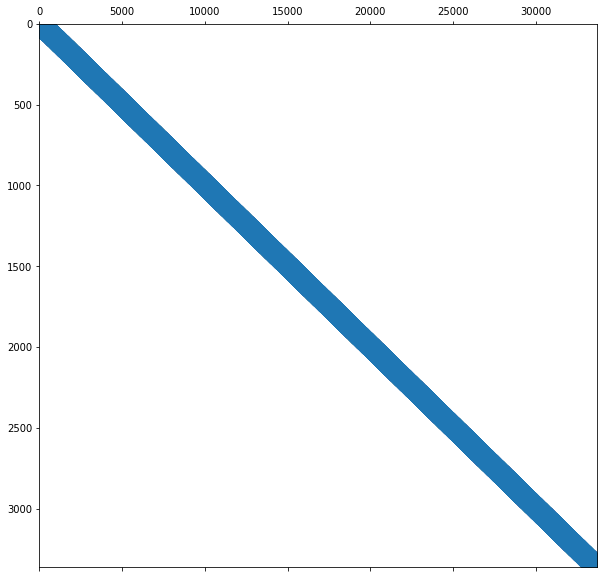

sparsity: 99.06253514215321


In [40]:
plt.figure(figsize=(10,10))
plt.spy(de_wu2,marker='.',aspect='auto')
plt.show()
print('sparsity:',(1-np.nonzero(de_wu2)[0].size/de_wu2.size)*100)

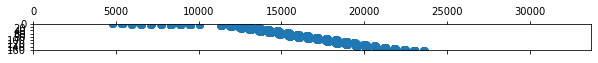

sparsity: 99.05128965312778


In [41]:
plt.figure(figsize=(10,10*z_uA.size/de_wu2.shape[0]))
plt.spy(de_wu2[z_uA],marker='.',aspect='auto')
plt.show()
print('sparsity:',(1-np.nonzero(de_wu2[z_uA])[0].size/de_wu2[z_uA].size)*100)

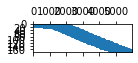

sparsity: 94.62184873949579


In [42]:
plt.figure(figsize=(10*wu2_sb_comp_dense.shape[1]/de_wu2.shape[1],10*wu2_sb_comp_dense.shape[0]/de_wu2.shape[0]))
plt.spy(wu2_sb_comp_dense,marker='.',aspect='auto')
plt.show()
print('sparsity:',(1-np.nonzero(wu2_sb_comp_dense)[0].size/wu2_sb_comp_dense.size)*100)

## Efficient version

In [43]:
maxitr=4
tol=1e-6

In [44]:
ZuTau1_cur=au1_cur[z_u]
ZuTAu2_cur=Au2_cur[z_u][:,z_uA]
ZuTau3_cur=au3_cur[z_u]

ZvTav1_cur=av1_cur[z_v]
ZvTav2_cur=av2_cur[z_v]
ZvTAv3_cur=Av3_cur[z_v][:,z_vA]

Au2T_curZu=Au2T_cur[z_uA][:,z_u]
Av3T_curZv=Av3T_cur[z_vA][:,z_v]

ZuTM=M[z_u][:,z_uM]
ZuTN=N[z_u][:,z_uN]
ZvTM=M[z_v][:,z_vM]
ZvTN=N[z_v][:,z_vN]

MTZu=MT[z_uM][:,z_u]
NTZu=NT[z_uN][:,z_u]
MTZv=MT[z_vM][:,z_v]
NTZv=NT[z_vN][:,z_v]

In [45]:
def ZuTtheta_u(g_u_sb,g_v_sb,ZuTMg_u,ZuTNg_u):
    return -1/dx*g_u_sb[z_u_ind]*ZuTMg_u-1/dy*g_v_sb[z_u_ind]*ZuTNg_u

def ZvTtheta_v(g_u_sb,g_v_sb,ZvTMg_v,ZvTNg_v):
    return -1/dx*g_u_sb[z_v_ind]*ZvTMg_v-1/dy*g_v_sb[z_v_ind]*ZvTNg_v

In [46]:
def dtheta_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu):
    return -1/dx*(ZuTMg_u*Jg_u_sbT[:,z_u_ind]+g_u_sb[z_u_ind]*Jg_uTMTZu)-1/dy*g_v_sb[z_u_ind]*Jg_uTNTZu

def dtheta_udv_hatTZu(ZuTNg_u,Jg_v_sbT):
    return -1/dy*ZuTNg_u*Jg_v_sbT[:,z_u_ind]

def dtheta_vdu_hatTZv(ZvTMg_v,Jg_u_sbT):
    return -1/dx*ZvTMg_v*Jg_u_sbT[:,z_v_ind]

def dtheta_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv):
    return -1/dx*g_u_sb[z_v_ind]*Jg_vTMTZv-1/dy*(ZvTNg_v*Jg_v_sbT[:,z_v_ind]+g_v_sb[z_v_ind]*Jg_vTNTZv)

In [47]:
def ZuTr_u(g_u_sb,g_v_sb,g_u_sb_prev,ZuTMg_u,ZuTNg_u):
    return g_u_sb[z_u_ind]-g_u_sb_prev[z_u_ind]-dt*(ZuTau1_cur+ZuTAu2_cur.dot(g_u_sb[z_uA_ind])+ZuTau3_cur*g_v_sb[z_u_ind]\
                                                    +ZuTtheta_u(g_u_sb,g_v_sb,ZuTMg_u,ZuTNg_u))

def ZvTr_v(g_u_sb,g_v_sb,g_v_sb_prev,ZvTMg_v,ZvTNg_v):
    return g_v_sb[z_v_ind]-g_v_sb_prev[z_v_ind]-dt*(ZvTav1_cur+ZvTav2_cur*g_u_sb[z_v_ind]+ZvTAv3_cur.dot(g_v_sb[z_vA_ind])\
                                                    +ZvTtheta_v(g_u_sb,g_v_sb,ZvTMg_v,ZvTNg_v))

In [48]:
def dr_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu):
    return Jg_u_sbT[:,z_u_ind]-dt*(sp.csr_matrix.dot(Jg_u_sbT[:,z_uA_ind],Au2T_curZu)\
                                   +dtheta_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu))

def dr_udv_hatTZu(ZuTNg_u,Jg_v_sbT):
    return -dt*(ZuTau3_cur*Jg_v_sbT[:,z_u_ind]+dtheta_udv_hatTZu(ZuTNg_u,Jg_v_sbT))

def dr_vdu_hatTZv(ZvTMg_v,Jg_u_sbT):
    return -dt*(ZvTav2_cur*Jg_u_sbT[:,z_v_ind]+dtheta_vdu_hatTZv(ZvTMg_v,Jg_u_sbT))

def dr_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv):
    return Jg_v_sbT[:,z_v_ind]-dt*(sp.csr_matrix.dot(Jg_v_sbT[:,z_vA_ind],Av3T_curZv)\
                                   +dtheta_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv))

In [49]:
def r_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur):
    r_u_hat=dr_udu_hatTZu_cur.dot(PuTPu.dot(ZuTr_u_cur))+dr_vdu_hatTZv_cur.dot(PvTPv.dot(ZvTr_v_cur))
    r_v_hat=dr_udv_hatTZu_cur.dot(PuTPu.dot(ZuTr_u_cur))+dr_vdv_hatTZv_cur.dot(PvTPv.dot(ZvTr_v_cur))
    return np.concatenate((r_u_hat,r_v_hat))

In [50]:
def J_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur):
    J11_hat=dr_udu_hatTZu_cur.dot(PuTPu.dot(dr_udu_hatTZu_cur.T))+dr_vdu_hatTZv_cur.dot(PvTPv.dot(dr_vdu_hatTZv_cur.T))
    J12_hat=dr_udu_hatTZu_cur.dot(PuTPu.dot(dr_udv_hatTZu_cur.T))+dr_vdu_hatTZv_cur.dot(PvTPv.dot(dr_vdv_hatTZv_cur.T))
    J21_hat=dr_udv_hatTZu_cur.dot(PuTPu.dot(dr_udu_hatTZu_cur.T))+dr_vdv_hatTZv_cur.dot(PvTPv.dot(dr_vdu_hatTZv_cur.T))
    J22_hat=dr_udv_hatTZu_cur.dot(PuTPu.dot(dr_udv_hatTZu_cur.T))+dr_vdv_hatTZv_cur.dot(PvTPv.dot(dr_vdv_hatTZv_cur.T))
    return np.block([[J11_hat,J12_hat],[J21_hat,J22_hat]])

In [51]:
t_start_pg_DEIM=time.time()

# solution
u_reduced=np.zeros((nt+1,latent_dim))
v_reduced=np.zeros((nt+1,latent_dim))
u_rom_pg_DEIM=np.zeros((nt+1,ny*nx))
v_rom_pg_DEIM=np.zeros((nt+1,ny*nx))

# IC
u_reduced[0]=np.copy(u_hat0)
v_reduced[0]=np.copy(v_hat0)
u_rom_pg_DEIM[0]=np.copy(u0)
v_rom_pg_DEIM[0]=np.copy(v0)

for k in range(nt):
#     print("")
#     print(k,"th time step:")
    
    u_hat_prev=np.copy(u_reduced[k])
    v_hat_prev=np.copy(v_reduced[k])
    
    g_u_sb_prev=u_rom_pg_DEIM[k,free_raveled_indicies[z_union]]-u_ref[z_union]
    g_v_sb_prev=v_rom_pg_DEIM[k,free_raveled_indicies[z_union]]-v_ref[z_union]
    
    u_hat=np.copy(u_reduced[k])
    v_hat=np.copy(v_reduced[k])
    
    g_u_sb,Jg_u_sbT=decoder_u_sb_np_forward_backwardT(u_hat)
    g_v_sb,Jg_v_sbT=decoder_v_sb_np_forward_backwardT(v_hat)
    
    ZuTMg_u=ZuTM.dot(g_u_sb[z_uM_ind])
    ZuTNg_u=ZuTN.dot(g_u_sb[z_uN_ind])
    ZvTMg_v=ZvTM.dot(g_v_sb[z_vM_ind])
    ZvTNg_v=ZvTN.dot(g_v_sb[z_vN_ind])
    
    Jg_uTMTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uM_ind],MTZu)
    Jg_uTNTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uN_ind],NTZu)
    Jg_vTMTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vM_ind],MTZv)
    Jg_vTNTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vN_ind],NTZv)
    
    ZuTr_u_cur=ZuTr_u(g_u_sb,g_v_sb,g_u_sb_prev,ZuTMg_u,ZuTNg_u)
    ZvTr_v_cur=ZvTr_v(g_u_sb,g_v_sb,g_v_sb_prev,ZvTMg_v,ZvTNg_v)

    dr_udu_hatTZu_cur=dr_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu)
    dr_udv_hatTZu_cur=dr_udv_hatTZu(ZuTNg_u,Jg_v_sbT)
    dr_vdu_hatTZv_cur=dr_vdu_hatTZv(ZvTMg_v,Jg_u_sbT)
    dr_vdv_hatTZv_cur=dr_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv)

    residual_hat=r_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur)
    
    for itr in range(maxitr):
        Jacobian_hat=J_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur)
        
        delta_reduced=np.linalg.solve(Jacobian_hat,-residual_hat)
        
        u_hat+=delta_reduced[:latent_dim]
        v_hat+=delta_reduced[latent_dim:]
        
        g_u_sb,Jg_u_sbT=decoder_u_sb_np_forward_backwardT(u_hat)
        g_v_sb,Jg_v_sbT=decoder_v_sb_np_forward_backwardT(v_hat)

        ZuTMg_u=ZuTM.dot(g_u_sb[z_uM_ind])
        ZuTNg_u=ZuTN.dot(g_u_sb[z_uN_ind])
        ZvTMg_v=ZvTM.dot(g_v_sb[z_vM_ind])
        ZvTNg_v=ZvTN.dot(g_v_sb[z_vN_ind])

        Jg_uTMTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uM_ind],MTZu)
        Jg_uTNTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uN_ind],NTZu)
        Jg_vTMTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vM_ind],MTZv)
        Jg_vTNTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vN_ind],NTZv)

        ZuTr_u_cur=ZuTr_u(g_u_sb,g_v_sb,g_u_sb_prev,ZuTMg_u,ZuTNg_u)
        ZvTr_v_cur=ZvTr_v(g_u_sb,g_v_sb,g_v_sb_prev,ZvTMg_v,ZvTNg_v)

        dr_udu_hatTZu_cur=dr_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu)
        dr_udv_hatTZu_cur=dr_udv_hatTZu(ZuTNg_u,Jg_v_sbT)
        dr_vdu_hatTZv_cur=dr_vdu_hatTZv(ZvTMg_v,Jg_u_sbT)
        dr_vdv_hatTZv_cur=dr_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv)
    
        residual_hat=r_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur)
        
        R=np.linalg.norm(residual_hat)
#         print(itr,"th Newton iteration", "R:", "{:.8e}".format(R))
        
        if R<tol:
            u_reduced[k+1]=u_hat.copy()
            v_reduced[k+1]=v_hat.copy()
            u_rom_pg_DEIM[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
            v_rom_pg_DEIM[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
            # BC from exact solution
            u_rom_pg_DEIM[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
            v_rom_pg_DEIM[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()
            break
            
    if R>=tol:
        print("\n non converged after {}th iteration".format(maxitr))
        break  

#     u_reduced[k+1]=u_hat.copy()
#     v_reduced[k+1]=v_hat.copy()
#     u_rom_pg_DEIM[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
#     v_rom_pg_DEIM[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
#     # BC from exact solution
#     u_rom_pg_DEIM[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
#     v_rom_pg_DEIM[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

t_elapsed_pg_DEIM=time.time()-t_start_pg_DEIM
print()
print('Time elapsed: {} sec'.format(t_elapsed_pg_DEIM))


Time elapsed: 13.762777090072632 sec


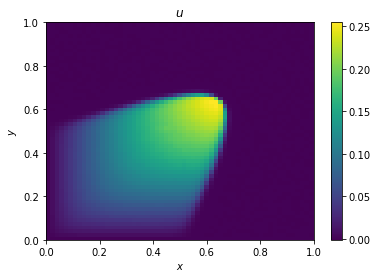

In [52]:
# plot
k=-1

fig_u = plt.figure()
# ax_u = Axes3D(fig_u)
# ax_u.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), (u_rom_pg_DEIM[k]).reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
# ax_u.view_init(elev=30,azim=30)
ax_u = fig_u.gca()
p_u=ax_u.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (u_rom_pg_DEIM[k]).reshape(ny,nx))
cb_u=fig_u.colorbar(p_u,ax=ax_u)
ax_u.set_xlabel('$x$')
ax_u.set_ylabel('$y$')
plt.title('$u$')
plt.show()

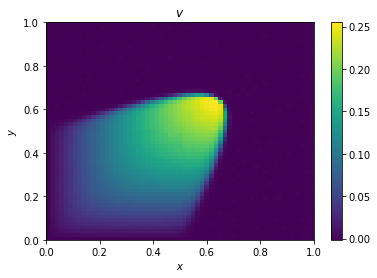

In [53]:
fig_v = plt.figure()
# ax_v = Axes3D(fig_v)
# ax_v.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), (vv_rom_pg_DEIM[k]).reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
# ax_v.view_init(elev=30,azim=60)
ax_v = fig_v.gca()
p_v=ax_v.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (v_rom_pg_DEIM[k]).reshape(ny,nx))
cb_v=fig_v.colorbar(p_v,ax=ax_v)
ax_v.set_xlabel('$x$')
ax_v.set_ylabel('$y$')
plt.title('$v$')
plt.show()

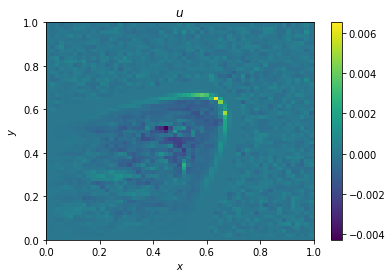

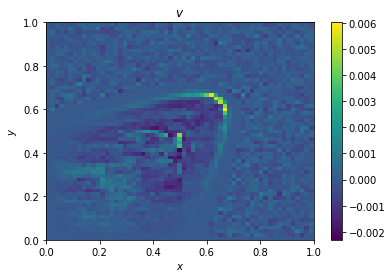

In [54]:
# plot
k=-1

fig_u = plt.figure()
# ax_u = Axes3D(fig_u)
# ax_u.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), (u_full[k]-u_rom_pg_DEIM[k]).reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
# ax_u.view_init(elev=30,azim=30)
ax_u = fig_u.gca()
p_u=ax_u.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (u_full[k]-u_rom_pg_DEIM[k]).reshape(ny,nx))
cb_u=fig_u.colorbar(p_u,ax=ax_u)
ax_u.set_xlabel('$x$')
ax_u.set_ylabel('$y$')
plt.title('$u$')
plt.show()

fig_v = plt.figure()
# ax_v = Axes3D(fig_v)
# ax_v.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), (v_full[k]-v_rom_pg_DEIM[k]).reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
# ax_v.view_init(elev=30,azim=60)
ax_v = fig_v.gca()
p_v=ax_v.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (v_full[k]-v_rom_pg_DEIM[k]).reshape(ny,nx))
cb_v=fig_v.colorbar(p_v,ax=ax_v)
ax_v.set_xlabel('$x$')
ax_v.set_ylabel('$y$')
plt.title('$v$')
plt.show()

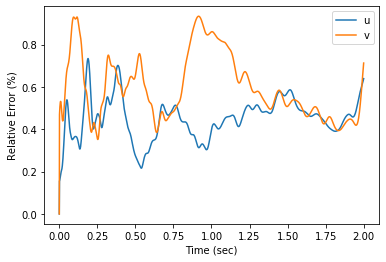

average relative error of u: 0.45467869263487853%
average relative error of v: 0.6416275902335863%

maximum relative error of u: 0.7340606841482201%
maximum relative error of v: 0.9339927943691113%


In [55]:
u_rel_err=np.linalg.norm(u_full-u_rom_pg_DEIM,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
v_rel_err=np.linalg.norm(v_full-v_rom_pg_DEIM,ord=2,axis=1)/np.linalg.norm(v_full,ord=2,axis=1)*100
plt.plot(dt*np.arange(nt+1),u_rel_err,dt*np.arange(nt+1),v_rel_err)
plt.xlabel('Time (sec)')
plt.ylabel('Relative Error (%)')
plt.legend(('u','v'))
plt.show()

u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_rom_pg_DEIM,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
v_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(v_full-v_rom_pg_DEIM,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(v_full,ord=2,axis=1)**2))*100

print("average relative error of u: {}%".format(u_avg_rel_err))
print("average relative error of v: {}%".format(v_avg_rel_err))
print()
print("maximum relative error of u: {}%".format(np.max(u_rel_err)))
print("maximum relative error of v: {}%".format(np.max(v_rel_err)))

In [56]:
# speed-up
speed_up=t_elapsed/t_elapsed_pg_DEIM
print("speed-up: {}".format(speed_up))

speed-up: 11.577881999029506


# Save data to mat file

In [57]:
ROM_pg_DEIM={'u_rom_lspg_hr':u_rom_pg_DEIM,'v_rom_lspg_hr':v_rom_pg_DEIM,'u':u_full,'v':v_full}

if Re==10000:
    file_name_ROM_pg_DEIM='./data/NMROM_high_Re.mat'
elif Re==100:
    file_name_ROM_pg_DEIM='./data/NMROM_low_Re.mat'
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

savemat(file_name_ROM_pg_DEIM, ROM_pg_DEIM)